# Healthcare No Show Modeling

- Train a ML model to forecast no show
- Recall for positive data is low - about half of the time, patients that did not show up are missed.
- Precision for positive data is very low - only about 35% of the predicted positive is correct.
- Based on the data analysis, they do not demonstrate clear pattern(s) to differentiate no shows.
    - Interpretation: a patient with certain traits is X% more likely to be no show.
- No show record of a patient might be a better factor.

In [1]:
import sys
sys.path.append("../..")  # add src to environment path so that custom modules can be found

import numpy as np
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.models.logistic_regression import LogisticRegressionClassifier
from src.models.mlp import MLPClassifier
from src.models.fttransformer import FTTransformerClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import matplotlib.pyplot as plt

## Load dataset

In [2]:
idx_cross_val = 0
full_dataset = torch.load(
    # f"../../data/healthcare_no_show/healthcare_datasets_base_{idx_cross_val}.pt",
    f"../../data/healthcare_no_show/healthcare_datasets_cats_{idx_cross_val}.pt",
    # f"../../data/healthcare_no_show/healthcare_datasets_reduced_{idx_cross_val}.pt",
    weights_only=False
)
train_dataset = full_dataset["train_dataset"]
val_dataset = full_dataset["val_dataset"]
feature_sizes = full_dataset["feature_cats"]
n_classes = full_dataset["class_size"] if full_dataset["class_size"] > 2 else 1
class_weights = full_dataset["class_weights"]
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [3]:
train_x = []
train_y = []
for feature, label in train_dataset:
    train_x.append(feature.numpy())
    train_y.append(label.numpy())

train_x = np.vstack(train_x)
# train_x = train_x[:, [8, 9, 1, 7]]
train_y = np.vstack(train_y).flatten()

print(train_x.shape)
print(train_y.shape)

val_x = []
val_y = []
for feature, label in val_dataset:
    val_x.append(feature.numpy())
    val_y.append(label.numpy())

val_x = np.vstack(val_x)
# val_x = val_x[:, [8, 9, 1, 7]]
val_y = np.vstack(val_y).flatten()

print(val_x.shape)
print(val_y.shape)

(88416, 10)
(88416,)
(22105, 10)
(22105,)


## Hyperparameters, functions, and model initialization

In [ ]:
# For tensorboard
writer = SummaryWriter(f"../../runs/healthcare_no_show_data{idx_cross_val}")

In [3]:
# Initializations that don't change with experiments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weights[1]]).cuda())

In [11]:
# Reset random seed
torch.manual_seed(1234)

In [62]:
model = RandomForestClassifier(
    # n_estimators=5,
    criterion="log_loss",
    # max_depth=4,
    class_weight='balanced',
    random_state=1234,
    n_jobs=4,
    verbose=1
)

In [72]:
model = xgb.XGBClassifier(
    # max_depth=4,
    learning_rate=0.3,
    # n_estimators=100,
    # min_child_weight=1,
    # subsample=0.6,
    # colsample_bytree=0.8,
    scale_pos_weight=1.5,
    gamma=1,
    objective='binary:logistic',
    random_state=1234
)

In [ ]:
model = LogisticRegressionClassifier(
    feature_cats=feature_sizes,
    num_classes=n_classes
).to(device)

In [ ]:
model = MLPClassifier(
    feature_cats=feature_sizes,
    num_classes=n_classes,
    num_hidden_neurons=192,
    num_hidden_layers=1,
    dropout=0.3
).to(device)

In [ ]:
model = FTTransformerClassifier(
    feature_cats=feature_sizes,
    num_classes=n_classes,
    d_model=256,
    num_encoder_layers=3,
    dim_feedforward=384,
    dropout=0.1
).to(device)

In [ ]:
# Separate optimizer for bias, norm and inputs with weight decay = 0
params_set1 = []
params_set2 = []
for name, param in model.named_parameters():
    if "cls_token" not in name and "embeddings" not in name and "bias" not in name and "norm" not in name:
        params_set1.append(param)
    else:
        params_set2.append(param)

optimizer1 = torch.optim.AdamW(params_set1, lr=1e-4, weight_decay=1e-5)
optimizer2 = torch.optim.AdamW(params_set2, lr=1e-4, weight_decay=0)
optimizer = [optimizer1, optimizer2]

In [12]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Used by FT-Transformer

In [ ]:
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-2)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-2)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

In [13]:
# Schedule learning rate reduction
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

## Train model

In [73]:
model.fit(train_x, train_y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for iter_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        if isinstance(optimizer, list):
            [x.zero_grad() for x in optimizer]
        else:
            optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()

        if isinstance(optimizer, list):
            [x.step() for x in optimizer]
        else:
            optimizer.step()

        running_loss += loss.item()

        if "writer" in globals():
            writer.add_scalar("Loss/train", loss.item(), epoch * len(train_loader) + iter_idx)
    
    if "scheduler" in globals():
        scheduler.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

        if "writer" in globals():
            writer.add_scalar("Loss/val", val_loss / len(val_loader), epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch [1/100], Loss: 0.7668, Val Loss: 0.7506
Epoch [2/100], Loss: 0.7525, Val Loss: 0.7501
Epoch [3/100], Loss: 0.7501, Val Loss: 0.7500
Epoch [4/100], Loss: 0.7494, Val Loss: 0.7501
Epoch [5/100], Loss: 0.7479, Val Loss: 0.7480
Epoch [6/100], Loss: 0.7480, Val Loss: 0.7476
Epoch [7/100], Loss: 0.7468, Val Loss: 0.7482
Epoch [8/100], Loss: 0.7466, Val Loss: 0.7492
Epoch [9/100], Loss: 0.7462, Val Loss: 0.7475
Epoch [10/100], Loss: 0.7455, Val Loss: 0.7479
Epoch [11/100], Loss: 0.7451, Val Loss: 0.7476
Epoch [12/100], Loss: 0.7447, Val Loss: 0.7472
Epoch [13/100], Loss: 0.7444, Val Loss: 0.7471
Epoch [14/100], Loss: 0.7445, Val Loss: 0.7478
Epoch [15/100], Loss: 0.7439, Val Loss: 0.7486
Epoch [16/100], Loss: 0.7435, Val Loss: 0.7484
Epoch [17/100], Loss: 0.7436, Val Loss: 0.7483
Epoch [18/100], Loss: 0.7434, Val Loss: 0.7487
Epoch [19/100], Loss: 0.7433, Val Loss: 0.7476
Epoch [20/100], Loss: 0.7428, Val Loss: 0.7479
Epoch [21/100], Loss: 0.7418, Val Loss: 0.7514
Epoch [22/100], Loss: 

## Compute accuracy

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.show()

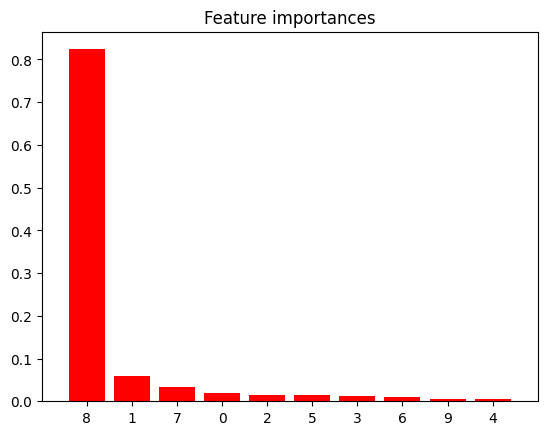

In [21]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.show()

In [77]:
threshold = 0.5
pred_y = model.predict_proba(val_x)
pred_y = pred_y[:,1] >= threshold
print(classification_report(val_y, pred_y, digits=4))

              precision    recall  f1-score   support

         0.0     0.8090    0.9648    0.8801     17619
         1.0     0.4328    0.1054    0.1696      4486

    accuracy                         0.7904     22105
   macro avg     0.6209    0.5351    0.5248     22105
weighted avg     0.7327    0.7904    0.7359     22105



In [ ]:
threshold = 0.5
preds = []
trues = []
model.eval()
with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        outputs = model(features)
        predictions = torch.sigmoid(outputs.squeeze()).cpu().numpy()
        preds.append(predictions)
        trues.append(labels.numpy())

preds = np.concat(preds, axis=0) >= threshold
trues = np.concat(trues, axis=0)
print(classification_report(trues, preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.8605    0.7649    0.8099     17619
         1.0     0.3572    0.5132    0.4212      4486

    accuracy                         0.7138     22105
   macro avg     0.6089    0.6390    0.6156     22105
weighted avg     0.7584    0.7138    0.7310     22105



Notes:
* acc1 refers to accuracy of dataset 1

Results of MLP:

| model | opt type | LR | weight decay | acc | wprec | wrecall | wfscore | macprec | macrecall | macfscore |
|----|----|----|----|----|----|----|----|----|----|----|
| MLP | SGD | 1e-2 | 1e-2 | 0.7200 | 0.6991 | 0.7200 | 0.7057 | 0.6323 | 0.6076 | 0.6144 |
|  | SGD | 1e-3 | 1e-2 | 0.7215 | 0.7009 | 0.7215 | 0.7076 | 0.6325 | 0.6084 | 0.6152 |
|  | SGD | 1e-4 | 1e-2 | 0.7971 | 0.6353 | 0.7971 | 0.7070 | 0.3985 | 0.5000 | 0.4435 |
|  | SGD | 1e-2 | 1e-4 | 0.7017 | 0.6807 | 0.7017 | 0.6797 | 0.6502 | 0.6109 | 0.6157 |
|  | SGD | 1e-3 | 1e-4 | 0.6833 | 0.7665 | 0.6833 | 0.7101 | 0.6081 | 0.6538 | 0.6081 |
|  | SGD | 1e-4 | 1e-4 | 0.7014 | 0.7391 | 0.7014 | 0.7170 | 0.5854 | 0.6055 | 0.5900 |
|  | AdamW | 1e-3 | 1e-2 | 0.7097 | 0.6872 | 0.7097 | 0.6908 | 0.6423 | 0.6092 | 0.6155 |
|  | AdamW | 1e-3 | 1e-4 | 0.7117 | 0.6894 | 0.7117 | 0.6933 | 0.6430 | 0.6103 | 0.6168 |
|  | AdamW | 1e-3 | 1e-5 | 0.7127 | 0.6905 | 0.7127 | 0.6946 | 0.6434 | 0.6109 | 0.6175 |
|  | AdamW | 1e-4 | 1e-2 | 0.7078 | 0.6858 | 0.7078 | 0.6879 | 0.6466 | 0.6109 | 0.6169 |
|  | AdamW | 1e-4 | 1e-4 | 0.7079 | 0.6859 | 0.7079 | 0.6880 | 0.6466 | 0.6109 | 0.6169 |
|  | AdamW | 1e-4 | 1e-5 | 0.7079 | 0.6859 | 0.7079 | 0.6880 | 0.6466 | 0.6109 | 0.6169 |

## Store model

In [ ]:
torch.save(model.state_dict(), f"../../models/healthcare_no_show/transformer_classifier_data{idx_cross_val}.pth")